# Trash Classification using CNN

This notebook implements a simple CNN for classifying trash images into 6 categories:
- Cardboard
- Glass
- Metal
- Paper
- Plastic
- Trash

## 1. Install and Import Required Libraries

In [ ]:
# Install required packages
!pip install torch torchvision wandb pillow

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import wandb
import os
import matplotlib.pyplot as plt

## 2. Create Dataset Class

In [2]:
class TrashDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        
        # List of classes
        self.classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        
        # Load images and labels
        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(image_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

## 3. Define CNN Model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First layer: Conv -> ReLU -> MaxPool
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Second layer: Conv -> ReLU -> MaxPool
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 6)  # 6 classes
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc(x)
        return x

## 4. Setup Data and Model

In [4]:
# Initialize wandb
wandb.init(project="simple-trash-classification")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = TrashDataset(image_dir="./data_trash", transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rizkyade378 (rizkyade378-24). Use `wandb login --relogin` to force relogin


Using device: cpu


## 5. Training Function

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## 6. Training Loop

In [6]:
# Training settings
num_epochs = 10
history = {'loss': [], 'accuracy': []}

# Training loop
for epoch in range(num_epochs):
    loss, acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Store history
    history['loss'].append(loss)
    history['accuracy'].append(acc)
    
    # Log to wandb
    wandb.log({
        "epoch": epoch,
        "loss": loss,
        "accuracy": acc
    })
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

Epoch [1/10], Loss: 1.3783, Accuracy: 47.82%
Epoch [2/10], Loss: 0.7991, Accuracy: 71.67%
Epoch [3/10], Loss: 0.3691, Accuracy: 88.68%
Epoch [4/10], Loss: 0.1435, Accuracy: 96.04%
Epoch [5/10], Loss: 0.0646, Accuracy: 98.42%
Epoch [6/10], Loss: 0.0413, Accuracy: 99.05%
Epoch [7/10], Loss: 0.0388, Accuracy: 99.17%
Epoch [8/10], Loss: 0.0214, Accuracy: 99.66%
Epoch [9/10], Loss: 0.0136, Accuracy: 99.76%
Epoch [10/10], Loss: 0.0153, Accuracy: 99.76%


## 7. Plot Training Results

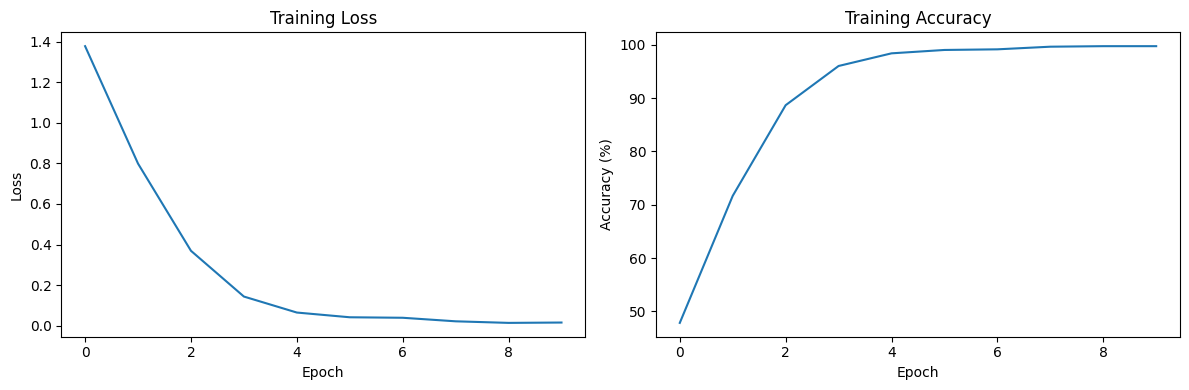

In [7]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

## 8. Save Model

In [8]:
# Save the trained model
torch.save(model.state_dict(), 'trash_classifier.pth')
print("Model saved successfully!")

# Close wandb run
wandb.finish()

Model saved successfully!


accuracy,▁▄▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▁▁▁▁▁▁
accuracy,99.76256
epoch,9
loss,0.01531


## Predict Image

In [9]:
def predict_image(image_path, model_path):
    # List of classes
    classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    
    # Load and prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Open and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        
        # Get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        
    # Get prediction and probability
    predicted_class = classes[predicted.item()]
    confidence = probabilities[predicted].item() * 100
    
    # Print results
    print(f"\nPredicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%\n")
    
    # Print all class probabilities
    print("Class Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{classes[i]}: {prob.item()*100:.2f}%")

In [18]:
if __name__ == "__main__":
    # Use raw string for Windows paths
    model_path = r"E:\File Kuliah\Project\Adamata - AI Engineering\trash_classifier.pth"
    image_path = r"E:\File Kuliah\Project\Adamata - AI Engineering\test2.jpeg"
    
    predict_image(image_path, model_path)


Predicted class: cardboard
Confidence: 99.84%

Class Probabilities:
cardboard: 99.84%
glass: 0.00%
metal: 0.00%
paper: 0.15%
plastic: 0.00%
trash: 0.00%


C:\Users\Rizky_Ade\AppData\Local\Temp\ipykernel_17684\2376484992.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locati